In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import wordpunct_tokenize
from collections import defaultdict
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
import random
import pylab
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from tqdm import tnrange, tqdm_notebook
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

/Users/bassim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('train.csv',index_col='id')
data.shape

(404290, 5)

In [3]:
data = data.sample(1000)

In [4]:
comb_ques = data['question1'].append(data['question2']).reset_index()
comb_ques.drop(['id'],axis=1,inplace=True)
comb_ques.columns = ['question']

In [5]:
# making a dictionary mapping a question to its duplicate question

correct = data[data['is_duplicate']==1]
correct_dict = {}
for x,y in zip(correct['question1'],correct['question2']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]
for x,y in zip(correct['question2'],correct['question1']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]

In [6]:
# Set Representation

set_dict={} # maps question id (eg 'm23') to set representation of question
norm_dict={} # maps question id (eg 'm23') to actual question. May use this dictionary to evaluate results of LSH output.
count=1
for question in tqdm_notebook([x for x in comb_ques['question'] if type(x)==str]):
    temp_list = []
    for shingle in question.split(' '):
        if shingle not in stop_words:
            temp_list.append(shingle.lower())
    set_dict["m{0}".format(count)] = set(temp_list)
    norm_dict["m{0}".format(count)] = question
    count +=1

In [7]:
# Create minHash signatures

num_perm = 256
min_dict = {} # maps question id (eg 'm23') to min hash signatures
count2 = 1
for val in tqdm_notebook(set_dict.values()): 
    m = MinHash(num_perm=num_perm)
    for shingle in val:
        m.update(shingle.encode('utf8'))
    min_dict["m{}".format(count2)] = m
    count2+=1

In [10]:
# Create LSH index

lsh = MinHashLSH(threshold=0.4, num_perm=num_perm)
for key in tqdm_notebook(min_dict.keys()):
    lsh.insert(key,min_dict[key])

In [25]:
def create_cand_pairs():
    big_list = []
    for query in min_dict.keys():
        bucket = lsh.query(min_dict[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list
        
        

In [26]:
cand_pairs = create_cand_pairs()

In [27]:
def evaluation(cand_pairs):
    tp = 0
    fp = 0
    fn = 0
    for pair in cand_pairs:
        if pair[1] == "None":
            if str(norm_dict[pair[0]]) in correct_dict.keys():
                    fn +=1
        else:
            if isinstance(correct_dict.get(norm_dict[pair[0]]), (list,)):
                if norm_dict[pair[1]] in correct_dict.get(norm_dict[pair[0]]):
                    tp +=1
                else:
                    fp +=1
                    
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    print ('precision is {}'.format(precision))
    print ('recall is {}'.format(recall))
        
        

In [28]:
evaluation(cand_pairs)

precision is 0.23709798055347794
recall is 0.5711711711711712


In [106]:
thresholds = [0.2,0.4,0.6,0.8]
precisions = [0.00,0.01,0.10,0.17]
recalls = [0.99,0.82,0.30,0.082]

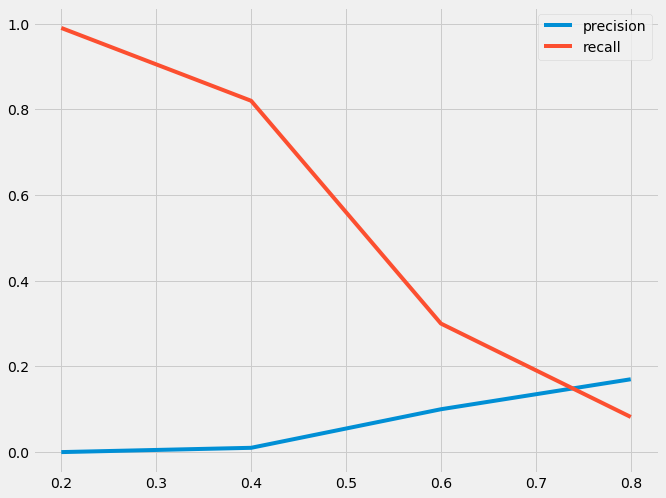

In [107]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))
sns.lineplot(x=thresholds,y=precisions, label="precision")
sns.lineplot(x=thresholds,y=recalls, label="recall")